In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
from kornia_moons.feature import *
from kornia_moons.viz import *

import pycolmap
import os
import h5py
import numpy as np
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cpu')



## Download example data

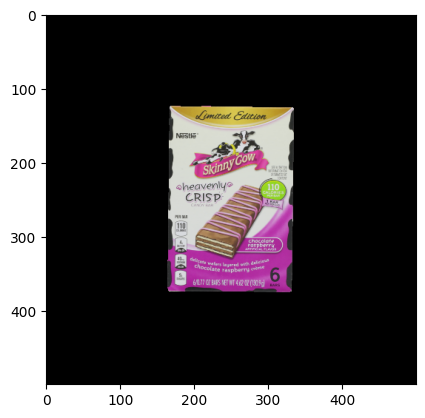

In [2]:
dirname = 'imc2023-kornia-starter-pack/data/Nestl_Skinny_Cow_Heavenly_Crisp_Candy_Bar_Chocolate_Raspberry_6_pack_462_oz_total'
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.png' in x][:-11]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

In [3]:
from kornia_moons.feature import laf_from_opencv_SIFT_kpts

def sift_to_rootsift(x: torch.Tensor, eps=1e-6) -> torch.Tensor:
    x = torch.nn.functional.normalize(x, p=1, dim=-1, eps=eps)
    x.clip_(min=eps).sqrt_()
    return torch.nn.functional.normalize(x, p=2, dim=-1, eps=eps)

def detect_sift(img_fnames,
                    num_feats = 2048,
                    device=torch.device('cpu'),
                    feature_dir = '.featureout', resize_to = (800, 600)):
    sift = cv2.SIFT_create(num_feats, edgeThreshold=-1000, contrastThreshold=-1000)
    if not os.path.isdir(feature_dir):
        os.makedirs(feature_dir)
    with h5py.File(f'{feature_dir}/lafs.h5', mode='w') as f_laf, \
         h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='w') as f_desc:
        for img_path in progress_bar(img_fnames):
            img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            hw1 = torch.tensor(img1.shape[:2], device=device)
            img_fname = img_path.split('/')[-1]
            key = img_fname
            kpts1, descs1 = sift.detectAndCompute(img1, None)
            lafs1 = laf_from_opencv_SIFT_kpts(kpts1)
            descs1 = sift_to_rootsift(torch.from_numpy(descs1)).to(device)
            desc_dim = descs1.shape[-1]
            kpts = KF.get_laf_center(lafs1).reshape(-1, 2).detach().cpu().numpy()
            descs1 = descs1.reshape(-1, desc_dim).detach().cpu().numpy()
            f_laf[key] = lafs1.detach().cpu().numpy()
            f_kp[key] = kpts
            f_desc[key] = descs1
    return


## Detect KeyNetAffNet features

In [4]:
detect_sift(img_fnames, 2048, device=device, resize_to=None)

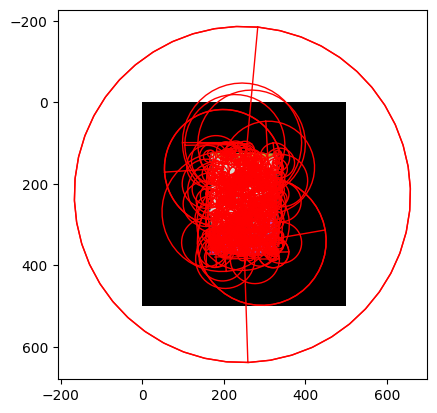

In [5]:
feature_dir = '.featureout'
with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf:
    img1 = load_torch_image(img_fnames[0])
    key = img_fnames[0].split('/')[-1]
    lafs = torch.from_numpy(f_laf[key][...])
    visualize_LAF(img1, lafs)


## Matching

In [6]:
def get_unique_idxs(A):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=0, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout',
                   device=torch.device('cpu'),
                   min_matches=15):
    matcher = K.feature.LightGlueMatcher('sift').eval().to(device)
    with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='r') as f_desc, \
        h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        with torch.inference_mode():
            for pair_idx in progress_bar(index_pairs):
                idx1, idx2 = pair_idx
                fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
                key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
                lafs1 = torch.from_numpy(f_laf[key1][...]).to(device)
                lafs2 = torch.from_numpy(f_laf[key2][...]).to(device)
                desc1 = torch.from_numpy(f_desc[key1][...]).to(device)
                desc2 = torch.from_numpy(f_desc[key2][...]).to(device)
                img1, img2 = cv2.imread(fname1), cv2.imread(fname2)
                hw1, hw2 = img1.shape[:2], img2.shape[:2]
                dists, idxs = matcher(desc1, desc2,
                                              lafs1, lafs2, # Adalam takes into account also geometric information
                                              hw1=hw1, hw2=hw2) # Adalam also benefits from knowing image size
                if len(idxs)  == 0:
                    continue
                n_matches = len(idxs)
                if False:
                    print (f'{key1}-{key2}: {n_matches} matches')
                group  = f_match.require_group(key1)
                if n_matches >= min_matches:
                     group.create_dataset(key2, data=idxs.detach().cpu().numpy().reshape(-1, 2))
    return


In [7]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [8]:
match_features(img_fnames, index_pairs, device=torch.device('cpu'))

Loaded LightGlue model


## Import into colmap and run reconstruction

In [9]:

from utils.colmap.h5_to_db import add_keypoints, add_matches
from utils.colmap.colmap_database import COLMAPDatabase


def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-pinhole', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

database_path = 'colmap.db'
!rm {database_path}
import_into_colmap(dirname, database_path=database_path)

rm: cannot remove 'colmap.db': No such file or directory


100%|██████████| 11/11 [00:00<00:00, 151.67it/s]
54it [00:00, 2051.69it/s]             


In [10]:
output_path = 'colmap_rec_sift'


In [11]:

def run_reconstruction_glomap(image_dir, output_path = 'glomap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    !glomap mapper --database_path {database_path} --output_path {output_path} --TrackEstablishment.min_num_view_per_track 2
    return 
run_reconstruction_glomap(dirname, 'glomap_rec_sift', database_path)

I20241113 14:01:01.743663 126776468539072 misc.cc:198] 
Feature matching
I20241113 14:01:01.744817 126777120749248 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.744949 126776510486208 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745115 126776585987776 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745149 126776787330752 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745181 126776795723456 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745335 126776745383616 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745527 126771918153408 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745585 126776594380480 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745616 126776636327616 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745701 126771909760704 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:01.745803 1

 Loading Images 11 / 11
 Loading Image Pair 54 / 54
I20241113 14:01:02.199790 37882 colmap_converter.cc:303] Pairs read done. 10 / 54 are invalid
I20241113 14:01:02.206144 37882 global_mapper.cc:80] Loaded database
-------------------------------------
Running preprocessing ...
-------------------------------------
I20241113 14:01:02.207257 37882 view_graph_manipulation.cc:249] Decompose relative pose for 0 pairs
I20241113 14:01:02.209940 37882 view_graph_manipulation.cc:303] Decompose relative pose done. 0 pairs are pure rotation
I20241113 14:01:02.221037 37882 timer.cc:87] Elapsed time: 0.01428 [seconds]
-------------------------------------
Running view graph calibration ...
-------------------------------------
I20241113 14:01:02.221434 37882 view_graph_calibration.cc:16] Start ViewGraphCalibrator
I20241113 14:01:02.263939 37882 view_graph_calibration.cc:148] 2 cameras are rejected in view graph calibration
I20241113 14:01:02.264058 37882 view_graph_calibration.cc:182] invalid / to

In [12]:

def run_reconstruction(image_dir, output_path = 'colmap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, dirname, output_path)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    maps[0].write(output_path)
    return maps

In [13]:
maps = run_reconstruction(dirname, output_path, database_path)

I20241113 14:01:09.284972 126771512989376 misc.cc:198] 
Feature matching
I20241113 14:01:09.285159 126771521382080 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285265 126777120749248 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285300 126771529774784 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285332 126771613636288 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285342 126776787330752 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285370 126776795723456 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285403 126776745383616 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285413 126776636327616 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285433 126776594380480 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285489 126776510486208 sift.cc:1457] Creating SIFT CPU feature matcher
I20241113 14:01:09.285552 1

In [14]:
print (maps[0].summary())

Reconstruction:
	num_reg_images = 9
	num_cameras = 9
	num_points3D = 520
	num_observations = 1654
	mean_track_length = 3.18077
	mean_observations_per_image = 183.778
	mean_reprojection_error = 0.407922


## Visualize with colmap GUI (yes, it is cheating)

In [15]:
!colmap gui

QObject::moveToThread: Current thread (0x637e0a79f180) is not the object's thread (0x637e0a7a2ef0).
Cannot move to target thread (0x637e0a79f180)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/home/tom/.local/lib/python3.10/site-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc.

*** Aborted at 1731502884 (unix time) try "date -d @1731502884" if you are using GNU date ***
PC: @                0x0 (unknown)
*** SIGABRT (@0x3e8000096df) received by PID 38623 (TID 0x71d4e1ffb800) from PID 38623; stack trace: ***
    @     0x71d4e86b5206 (unknown)
    @     0x71d4e6245320 (unknown)
    @     0x71d4e629eb1c pthread_kill
    @     0x71d4e624526e gsignal
    @     0x71d4e62288ff abort
    @     0x71d4e6a91104 QMessageLogger::fatal()
    @     0x71d4e71

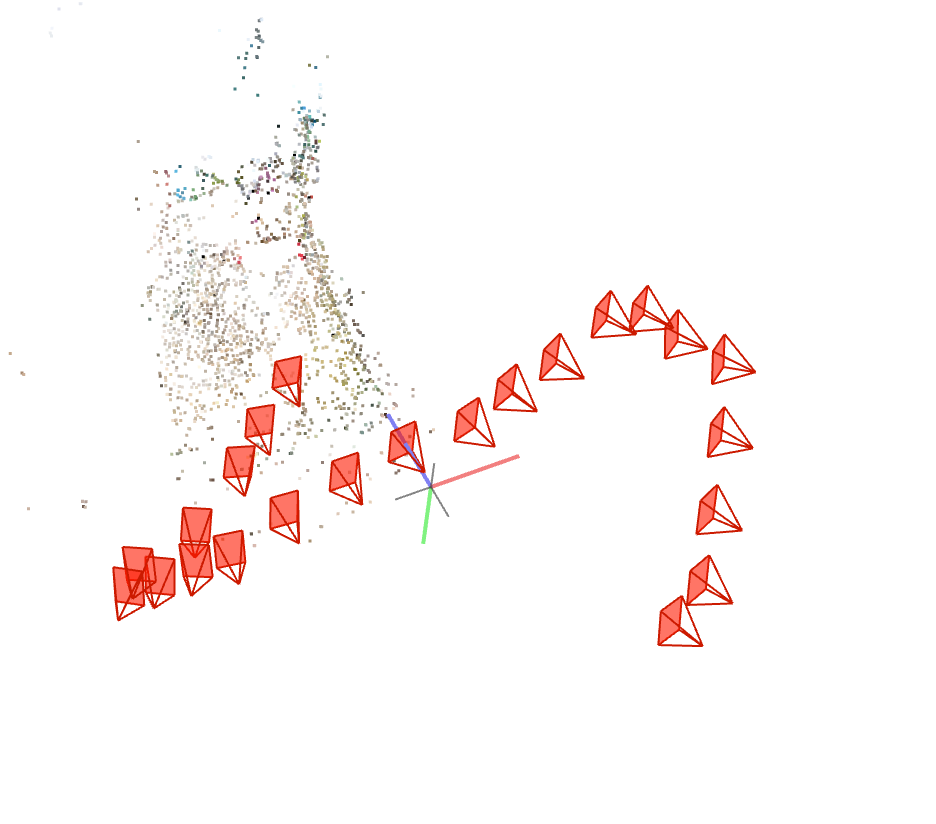